In [169]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import optuna

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
tr_df = pd.read_csv('data/transactions.csv', on_bad_lines='skip', sep=';')
print(tr_df.shape)
tr_df.head()

Columns (14,15,21,22) have mixed types.Specify dtype option on import or set low_memory=False.


(995975, 23)


,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project
0,13-7700-2022,02/06/2022 16:18,44581083,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,AKOYA OXYGEN,Land,Residential,570400.000,174.800,174.800,NaN,NaN,NaN,NaN,Dubai Cycling Course,0.000,0.000,NaN,DAMAC HILLS (2) - ODORA
1,13-7699-2022,02/06/2022 16:14,44014284,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,AKOYA OXYGEN,Land,Residential,530000.000,174.800,174.800,NaN,NaN,NaN,NaN,Dubai Cycling Course,0.000,0.000,NaN,DAMAC HILLS (2) - ZINNIA
2,14-563-2022,02/06/2022 15:42,280311,Mortgage,Modify Mortgage,Ready,Non Free Hold,Residential,Al Barshaa South First,Land,Residential,500000.000,1188.420,1188.420,NaN,NaN,Sharaf Dg Metro Station,Mall of the Emirates,Motor City,0.000,0.000,NaN,NaN
3,11-12317-2022,02/06/2022 15:22,79102731,Sales,Sale,Ready,Free Hold,Commercial,AL FURJAN,Land,Commercial,1500000.000,600.510,600.510,NaN,NaN,NaN,NaN,NaN,1.000,1.000,NaN,NaN
4,11-12316-2022,02/06/2022 15:07,132952797,Sales,Sale,Ready,Free Hold,Residential,AKOYA OXYGEN,Land,Residential,815000.000,112.240,112.240,NaN,NaN,NaN,NaN,Dubai Cycling Course,1.000,1.000,NaN,DAMAC HILLS (2) - AMARGO


## Date Parse

In [3]:
tr_df.loc[:, 'Transaction Date'] = tr_df['Transaction Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M"))
tr_df.loc[:, 'Transaction Year'] = tr_df['Transaction Date'].apply(lambda x: x.year)

In [4]:
tr_df = tr_df.loc[lambda x: x['Transaction Year'] >= 2007]
tr_df = tr_df.loc[lambda x: (~x['Property Size (sq.m)'].isna()) & (x['Property Size (sq.m)']>0)].copy()

## Build and Evaluate ML model efficacy

In [ ]:
target_col = 'Amount'
feature_cols = list(set(tr_df.columns) - set(['Amount', 'Property ID', 'Transaction Date', 'Transaction Number',
                                        'Transaction Size (sq.m)', 'Transaction Year']))

In [ ]:
#Typecast 'oject' in pandas to categorical
for c in feature_cols:
    col_type = tr_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        tr_df[c] = tr_df[c].astype('category')

In [108]:
## Train-Test split
X_train, X_test, y_train, y_test = train_test_split(tr_df.loc[:, feature_cols], 
                                                    tr_df.loc[:, target_col], 
                                                    test_size=0.20, random_state=7)

In [112]:
##Find Best Hyperparameters using Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e1, log=True),
    }
    model = lgb.LGBMRegressor(random_state=7, n_jobs=-1)
    model.set_params(**params)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return np.mean(cv_score)

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2023-05-22 09:58:42,645] A new study created in memory with name: no-name-7c8cf536-dd8c-46c7-b265-5d1b56c1ef5b
[I 2023-05-22 09:58:55,791] Trial 0 finished with value: 0.14491955131260917 and parameters: {'n_estimators': 210, 'learning_rate': 0.0038925319305342693, 'max_depth': 3, 'colsample_bytree': 0.6077941744947741, 'reg_lambda': 0.030347551107504162}. Best is trial 0 with value: 0.14491955131260917.
[I 2023-05-22 09:59:21,285] Trial 1 finished with value: 0.14639513043622804 and parameters: {'n_estimators': 330, 'learning_rate': 0.0014470169312864852, 'max_depth': 6, 'colsample_bytree': 0.721079977283506, 'reg_lambda': 0.0001715896526578152}. Best is trial 1 with value: 0.14639513043622804.
[I 2023-05-22 09:59:42,376] Trial 2 finished with value: 0.2973846168917936 and parameters: {'n_estimators': 250, 'learning_rate': 0.05009939511082961, 'max_depth': 4, 'colsample_bytree': 0.5104105685752641, 'reg_lambda': 0.00015676522695818457}. Best is trial 2 with value: 0.297384616891793

[I 2023-05-22 10:12:47,321] Trial 27 finished with value: 0.3705694758300858 and parameters: {'n_estimators': 360, 'learning_rate': 0.12721479290138088, 'max_depth': 6, 'colsample_bytree': 0.8012211984930898, 'reg_lambda': 1.7226242674173593e-05}. Best is trial 13 with value: 0.3735938333572474.
[I 2023-05-22 10:13:16,966] Trial 28 finished with value: 0.2885643694091168 and parameters: {'n_estimators': 360, 'learning_rate': 0.1301171173849109, 'max_depth': 4, 'colsample_bytree': 0.26942377461186673, 'reg_lambda': 1.4011553173802761e-05}. Best is trial 13 with value: 0.3735938333572474.
[I 2023-05-22 10:13:36,077] Trial 29 finished with value: 0.27460339155033886 and parameters: {'n_estimators': 290, 'learning_rate': 0.034217532784911756, 'max_depth': 3, 'colsample_bytree': 0.7982307139914191, 'reg_lambda': 0.018367954993115224}. Best is trial 13 with value: 0.3735938333572474.


In [113]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

final_params = trial.params

Number of finished trials: 30
Best trial:
  Value: 0.3735938333572474
  Params: 
    n_estimators: 420
    learning_rate: 0.141550145801601
    max_depth: 6
    colsample_bytree: 0.7680577947476517
    reg_lambda: 0.07136934238219186


## Test Predictions of the Model

In [114]:
model = lgb.LGBMRegressor(random_state=7, n_jobs=-1)
model.set_params(**final_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.7680577947476517,
              learning_rate=0.141550145801601, max_depth=6, n_estimators=420,
              random_state=7, reg_lambda=0.07136934238219186)

In [125]:
test_df = X_test.copy()
test_df.loc[:, 'Actual Amount'] = y_test.copy()
test_df.loc[:, 'Predicted Amount'] = model.predict(X_test)
test_df.reset_index(drop=True, inplace=True)
test_df.loc[:, 'pct_diff'] = ((abs(test_df['Actual Amount'] - test_df['Predicted Amount']))/test_df['Actual Amount'])*100.0

In [161]:
pct_bins = list(np.arange(0, 101, 10)) + [test_df.pct_diff.max()+1]
pct_labels = ['<'+str(b) for b in pct_bins[1:]]
pct_labels[-1] = '<max'

test_df.loc[:, 'pct_diff_bin'] = pd.cut(test_df['pct_diff'], bins = pct_bins,
                                       labels = pct_labels)

In [162]:
pct_diff_df = test_df['pct_diff_bin'].value_counts(normalize=True).sort_index().cumsum()
pct_diff_df

<10    0.222
<20    0.418
<30    0.569
<40    0.683
<50    0.756
<60    0.802
<70    0.834
<80    0.858
<90    0.877
<100   0.894
<max   1.000
Name: pct_diff_bin, dtype: float64

Text(0.5, 1.0, 'Fraction of Test cases predicted within a Tolerance Range')

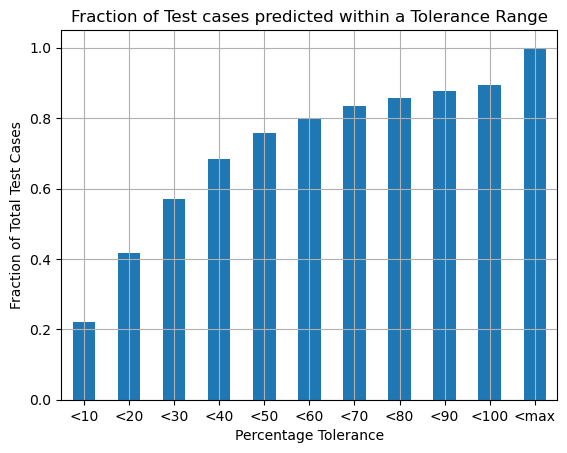

In [168]:
pct_diff_df.plot.bar()
plt.grid()
plt.xticks(rotation=0);
plt.ylabel('Fraction of Total Test Cases')
plt.xlabel('Percentage Tolerance')
plt.title('Fraction of Test cases predicted within a Tolerance Range')

In [170]:
#R2
r2_score(test_df['Actual Amount'], test_df['Predicted Amount'])

0.38870689762677935

## Analyze Importance of Factors over Time

In [193]:
test_years = list(range(2011, 2023))
test_years

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [194]:
def get_feature_importance_scores(test_year):
    #Assign Train, Test Df
    test_df = tr_df.loc[lambda x: x['Transaction Year'] == test_year].copy()
    train_df = tr_df.loc[lambda x: x['Transaction Year'] != test_year].copy()
    X_train = train_df.loc[:, feature_cols].copy()
    y_train = train_df.loc[:, target_col].copy()
    X_test = test_df.loc[:, feature_cols].copy()
    y_test = test_df.loc[:, target_col].copy()
    #Train Model
    model = lgb.LGBMRegressor(random_state=7, n_jobs=-1)
    model.set_params(**final_params)
    model.fit(X_train, y_train)
    #compute shap values
    shap_values = shap.TreeExplainer(model.booster_).shap_values(X_test)
    shap_df = pd.DataFrame(shap_values, columns = feature_cols)
    shap_series = (np.abs(shap_df)).mean(axis=0)
    return shap_series.to_frame(name=str(test_year)).T

In [197]:
shap_df_all = pd.DataFrame(columns=feature_cols)
for test_year in test_years:
    shap_df_local = get_feature_importance_scores(test_year)
    shap_df_all = pd.concat([shap_df_all, shap_df_local])

In [198]:
shap_df_all

,Transaction sub type,Nearest Mall,Nearest Landmark,Area,Room(s),Is Free Hold?,Property Type,Registration type,No. of Buyer,Project,Master Project,Property Size (sq.m),Transaction Type,Nearest Metro,Usage,Property Sub Type,No. of Seller,Parking
2011,634415.265,73835.578,434027.741,2414886.403,118239.931,228224.454,143220.356,1520.484,92097.836,257706.775,751.836,3838218.769,597239.731,778896.471,324427.200,766301.430,61789.953,28526.932
2012,655926.824,89152.612,329516.841,2626655.751,165611.891,270006.671,139623.994,3261.516,43544.015,416214.399,545.684,4396738.936,429565.524,917770.625,312418.528,777827.454,45213.984,28188.641
2013,627163.251,120745.752,385401.252,2683330.911,153068.808,279732.972,117587.559,2027.837,40125.641,377238.091,0.000,4110379.732,485838.850,1027090.346,348999.070,1177119.940,58574.669,29782.762
2014,731796.665,50747.898,365366.319,2312472.832,113000.331,245939.349,219041.123,3602.388,114282.314,290838.099,0.000,3610723.358,429033.143,824586.428,279675.039,1109969.236,46081.401,27654.637
2015,612964.872,103139.236,426456.396,2404143.437,115694.730,217364.581,115960.630,3600.709,42728.007,339106.972,493.642,3916953.903,466149.843,785981.837,253721.952,819661.156,69321.503,26739.366
2016,791768.032,106324.817,438922.631,2489035.301,167792.263,328772.169,152382.974,1812.675,66123.682,306905.922,668.476,4481467.438,489902.273,927614.870,332710.291,798954.340,77344.200,38410.683
2017,850163.859,97760.867,494877.994,2599080.771,159354.218,300556.584,155483.214,11400.720,88750.540,595207.293,0.000,4300731.881,614654.472,882727.894,239836.580,1108736.462,113547.604,74505.754
2018,1062529.011,160026.864,569976.240,2923792.524,128383.756,331091.217,351608.662,615.889,108280.906,411796.420,492.812,4626909.513,731411.522,1009237.065,341400.528,1005390.277,141509.511,76445.743
2019,674537.167,79469.069,430278.008,2345546.316,136506.960,267739.980,161296.506,6248.000,78870.726,392117.105,607.410,4196716.661,511677.475,780657.399,235257.999,899447.313,65243.889,98914.788
2020,653343.007,98802.723,394408.322,2055800.265,134534.729,256217.285,146722.694,4339.820,36931.032,348073.600,596.100,3658450.967,389855.595,781310.963,184600.703,929095.145,54626.056,54934.296


Text(0.5, 1.0, 'Shap Importances')

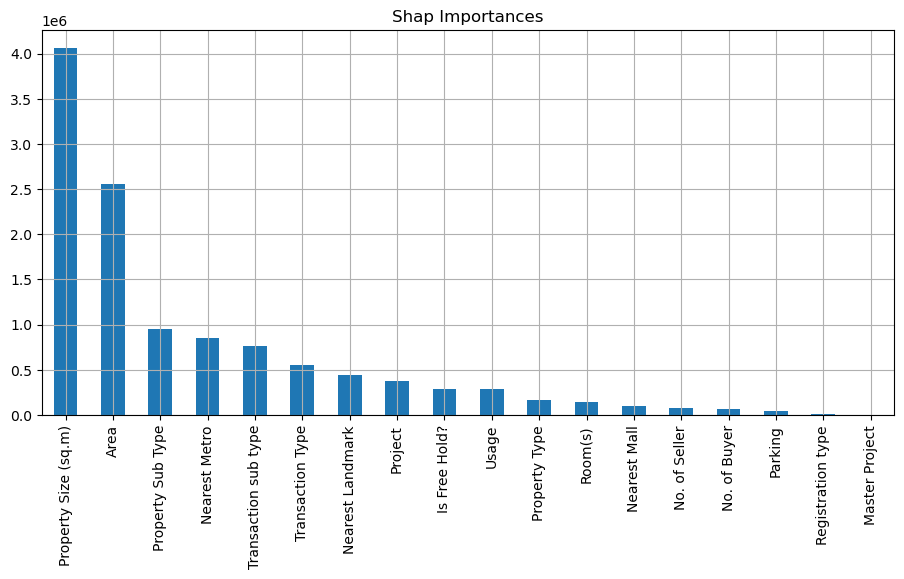

In [235]:
shap_df_all.mean(axis=0).sort_values(ascending=False).plot.bar(figsize=(11,5))
plt.grid()
plt.title('Shap Importances')

In [222]:
list_imp_features = shap_df_all.mean(axis=0).sort_values(ascending=False).index.to_list()

In [218]:
shap_df_ranked = shap_df_all.rank(axis=1)
shap_df_ranked

,Transaction sub type,Nearest Mall,Nearest Landmark,Area,Room(s),Is Free Hold?,Property Type,Registration type,No. of Buyer,Project,Master Project,Property Size (sq.m),Transaction Type,Nearest Metro,Usage,Property Sub Type,No. of Seller,Parking
2011,14.000,5.000,12.000,17.000,7.000,9.000,8.000,2.000,6.000,10.000,1.000,18.000,13.000,16.000,11.000,15.000,4.000,3.000
2012,14.000,6.000,11.000,17.000,8.000,9.000,7.000,2.000,4.000,12.000,1.000,18.000,13.000,16.000,10.000,15.000,5.000,3.000
2013,14.000,7.000,12.000,17.000,8.000,9.000,6.000,2.000,4.000,11.000,1.000,18.000,13.000,15.000,10.000,16.000,5.000,3.000
2014,14.000,5.000,12.000,17.000,6.000,9.000,8.000,2.000,7.000,11.000,1.000,18.000,13.000,15.000,10.000,16.000,4.000,3.000
2015,14.000,6.000,12.000,17.000,7.000,9.000,8.000,2.000,4.000,11.000,1.000,18.000,13.000,15.000,10.000,16.000,5.000,3.000
2016,14.000,6.000,12.000,17.000,8.000,10.000,7.000,2.000,4.000,9.000,1.000,18.000,13.000,16.000,11.000,15.000,5.000,3.000
2017,14.000,5.000,11.000,17.000,8.000,10.000,7.000,2.000,4.000,12.000,1.000,18.000,13.000,15.000,9.000,16.000,6.000,3.000
2018,16.000,7.000,12.000,17.000,5.000,8.000,10.000,2.000,4.000,11.000,1.000,18.000,13.000,15.000,9.000,14.000,6.000,3.000
2019,14.000,5.000,12.000,17.000,7.000,10.000,8.000,2.000,4.000,11.000,1.000,18.000,13.000,15.000,9.000,16.000,3.000,6.000
2020,14.000,6.000,13.000,17.000,7.000,10.000,8.000,2.000,3.000,11.000,1.000,18.000,12.000,15.000,9.000,16.000,4.000,5.000


## Save plots of Factor Importance ranks

In [233]:
from matplotlib.backends.backend_pdf import PdfPages
pdf_session = PdfPages('importance_rank.pdf')

In [234]:
for f in list_imp_features:
    plt.figure()
    shap_df_ranked[f].plot.bar()
    plt.title(f)
    plt.grid()
    plt.ylim(1, 18)
    plt.ylabel('Rank (higher is better)')
    pdf_session.savefig()
    plt.close()
pdf_session.close()